# Loan and housing data —BI Analytics

---
por [<span style="font-family:monospace;">Andres Ethorimn</span>](https://www.linkedin.com/in/ethlob/) 👨🏾‍💻

<span style="color:blue; font-weight:bold;">Análisis Exploratorio:</span> en este notebook vamos a realizar un análisis exploratorio de datos (EDA) profundo de los clusters identificados previamente con técnicas de análisis BI para contexto de negocio. Examinaremos el comportamiento demográfico, financiero y de contacto de cada segmento, analizando las relaciones entre variables y patrones de conversión por target. El objetivo es generar insights accionables para estrategias de marketing dirigido y optimización de campañas futuras.

<span style="font-size:small; color:gray;">*Los notebooks en esta sección son prototipos. Su uso es exclusivo para exploración y aprendizaje, y no están pensado para usarse en producción. Tenga presente que los comentarios de aquí en adelante estarán en inglés por ser el idioma estándar de la industria.*</span>

In [76]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better looking plots
plt.style.use('ggplot')
sns.set_palette('husl')

import warnings
warnings.filterwarnings('ignore')

from scipy import stats

In [77]:
# Define data directory
parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, 'data')

In [78]:
# Set random state for further implementations
random_state = 11

In [79]:
# Load the data from the Excel file in staging directory
data_raw = pd.read_excel(os.path.join(data_dir, 'staging', '01_data_prueba_ds_loan_housing_basic_schema.xlsx'), engine='openpyxl', index_col=0)
data_raw.drop(columns=['housing', 'loan', 'default', 'tenencia_corriente', 'pdays', 'contact', 'poutcome'], inplace=True, errors='raise')

data_target = pd.read_excel(os.path.join(data_dir, 'staging', '02_data_prueba_ds_loan_housing_target.xlsx'), engine='openpyxl', index_col=0)
data_contact = pd.read_excel(os.path.join(data_dir, 'staging', '02_data_prueba_ds_loan_housing_contacted.xlsx'), engine='openpyxl', index_col=0)
data_cluster = pd.read_excel(os.path.join(data_dir, 'staging', '03_data_prueba_ds_loan_housing_clusters.xlsx'), engine='openpyxl', index_col=0)

In [80]:
data_bi = pd.merge(data_raw, data_contact, how='inner', left_index=True, right_index=True)
data_bi = pd.merge(data_bi, data_target, how='inner', left_index=True, right_index=True)
data_bi = pd.merge(data_bi, data_cluster, how='inner', left_index=True, right_index=True)

Text(0.5, 25.722222222222214, 'Target')

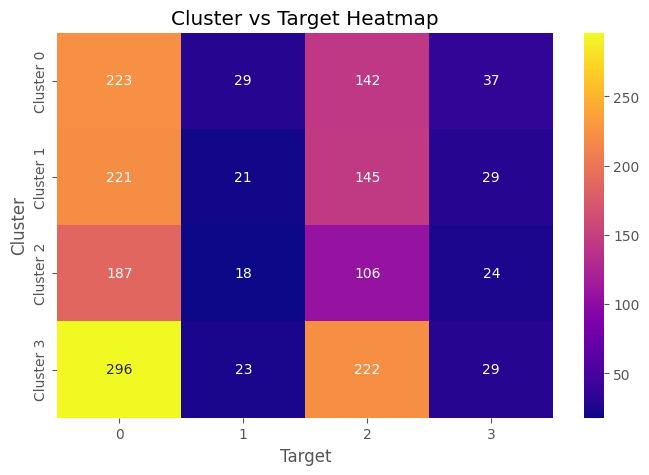

In [81]:
%matplotlib inline
ct = pd.crosstab(data_bi.cluster, data_bi.target, dropna=True)
plt.figure(figsize=(8, 5))
sns.heatmap(ct, annot=True, fmt='d', cmap='plasma')
plt.title('Cluster vs Target Heatmap')
plt.ylabel('Cluster')
plt.xlabel('Target')

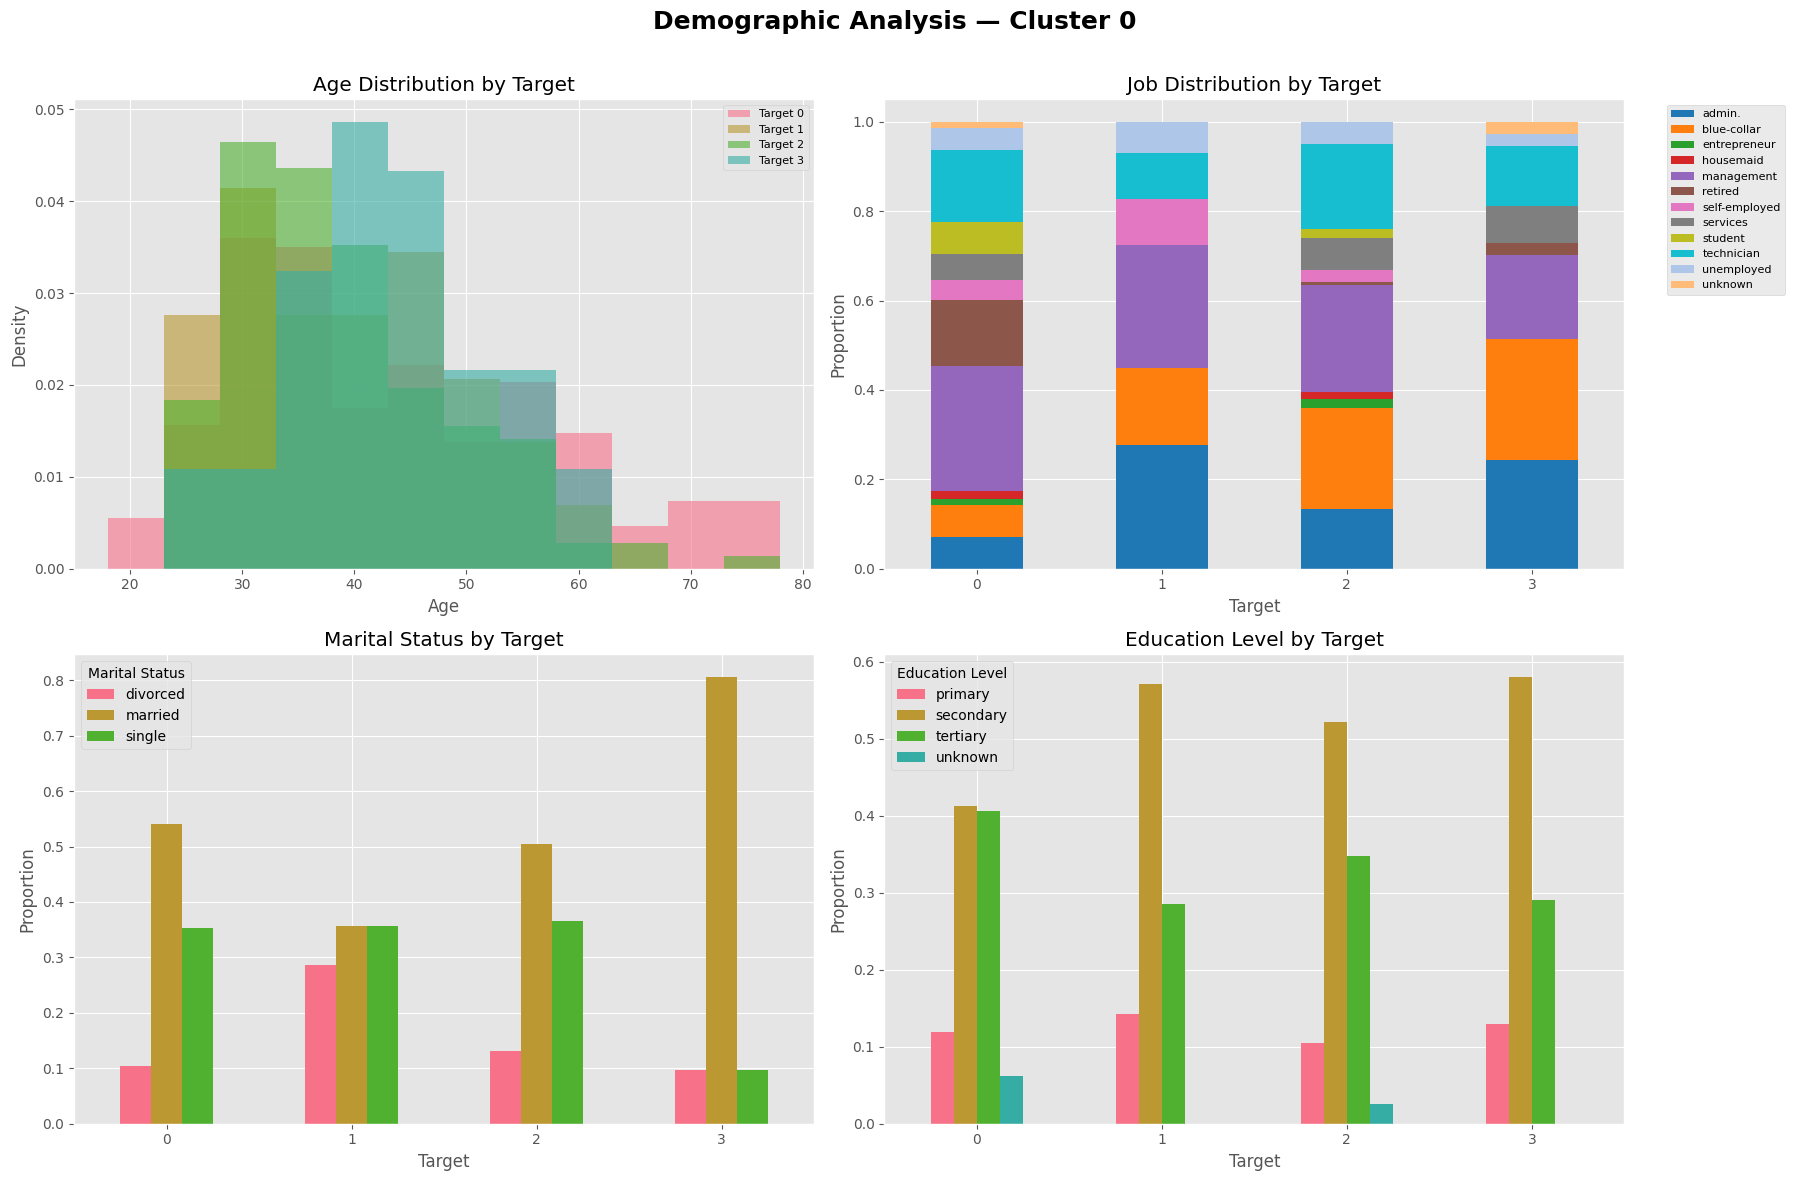

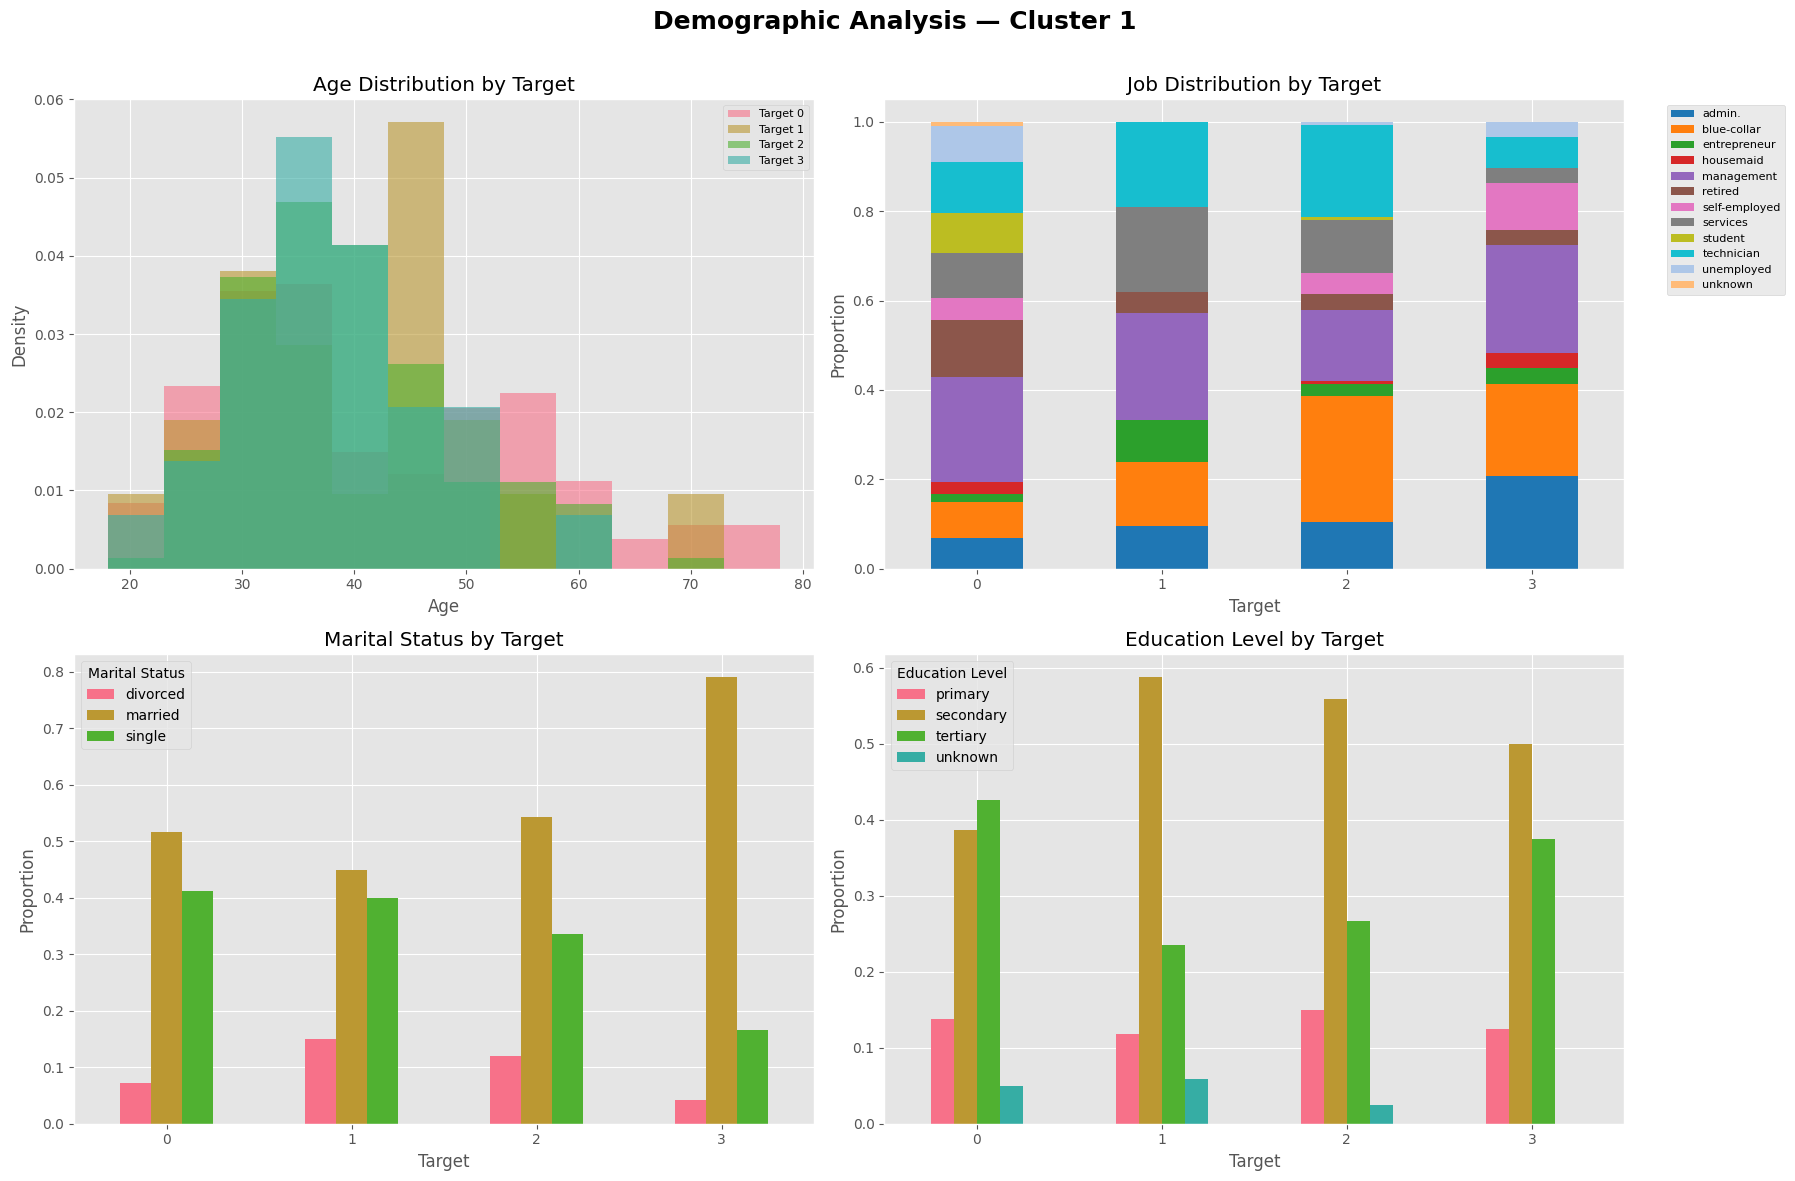

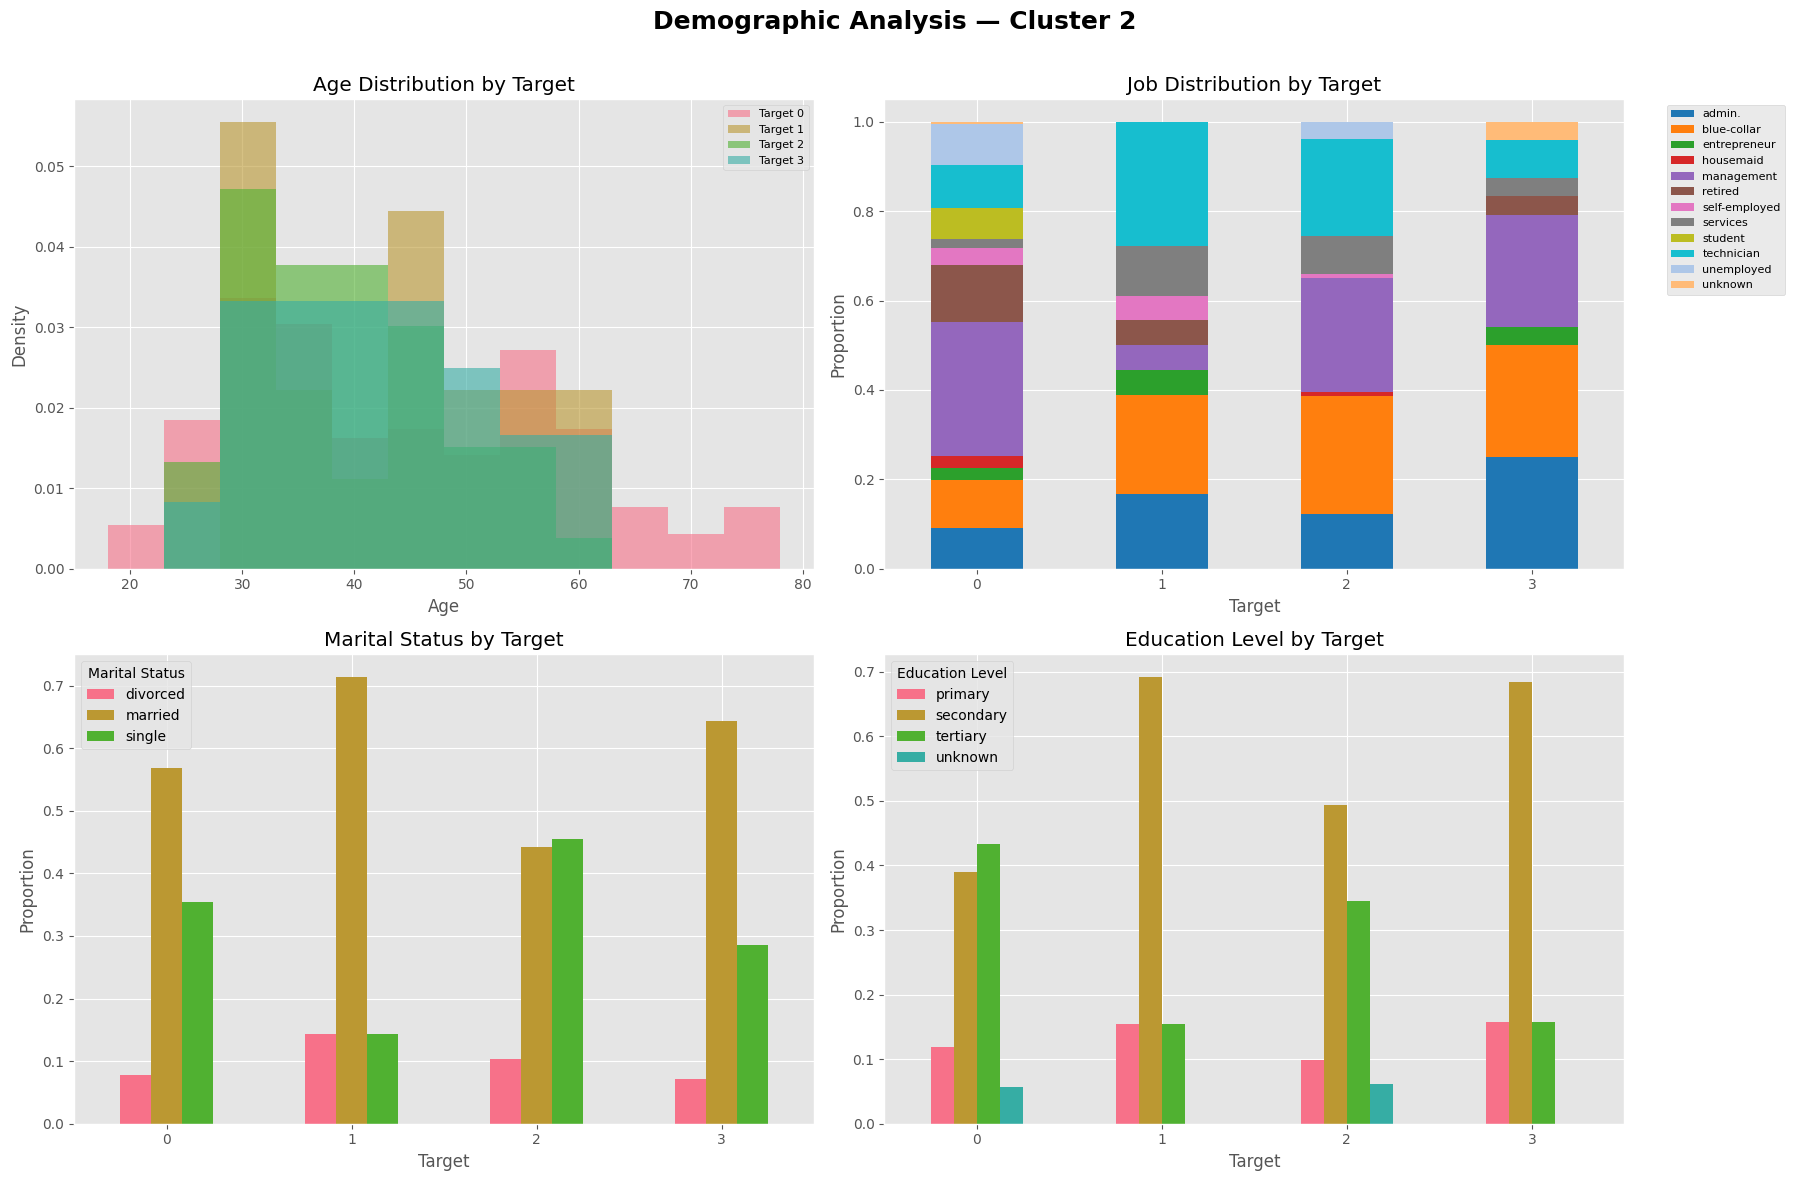

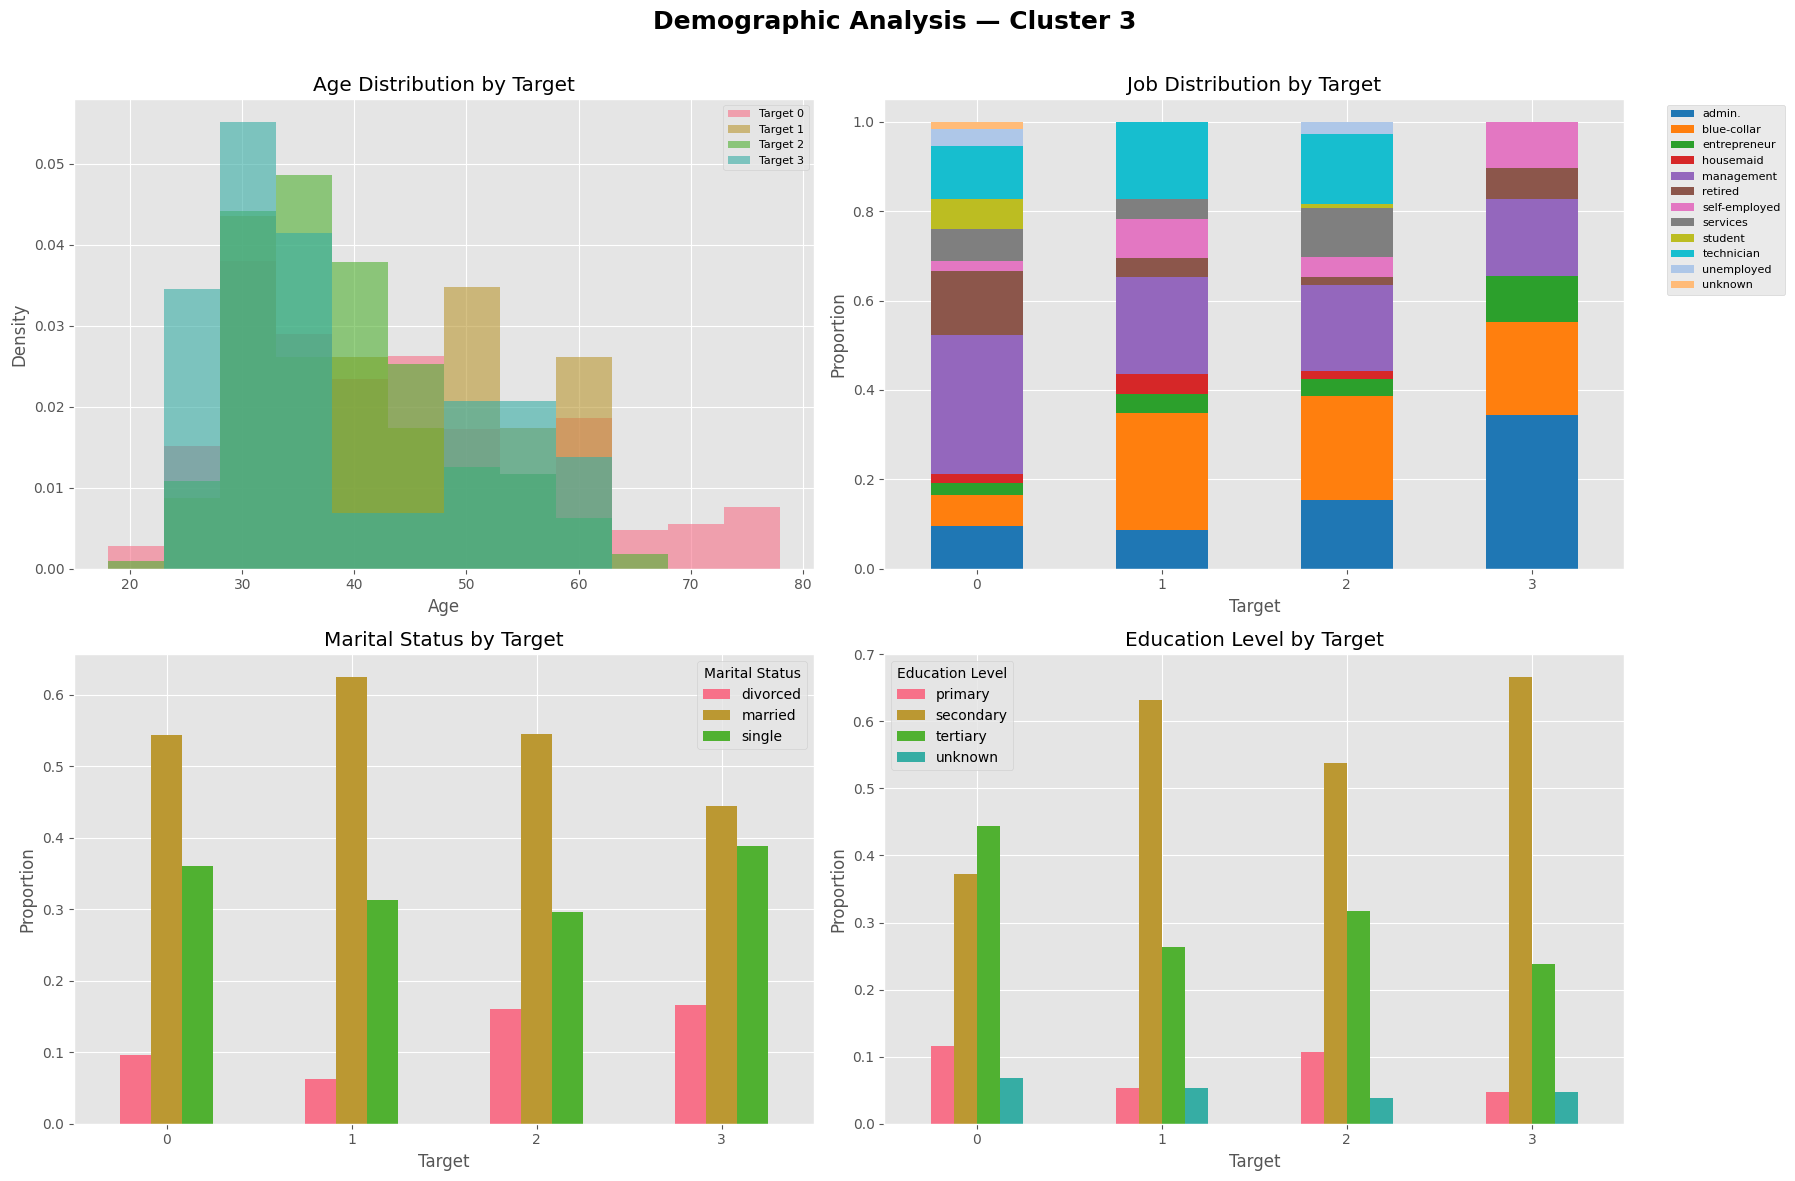

In [82]:
clusters = sorted(data_bi['cluster'].unique())

# Desagregación de análisis demográfico por cluster
age_bins = range(18, 81, 5)  # Age bins from 18 to 80 in 5-year intervals
targets = sorted(data_bi['target'].unique())

for cluster in clusters:
    cluster_data = data_bi[data_bi['cluster'] == cluster]
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f'Demographic Analysis — {cluster}', fontsize=18, fontweight='bold')
    
    # 1. Age Distribution por target
    for target_val in targets:
        target_cluster_data = cluster_data[cluster_data['target'] == target_val]
        if len(target_cluster_data) > 0:
            axes[0, 0].hist(target_cluster_data['age'], bins=age_bins, alpha=0.6, 
                            label=f'Target {target_val}', density=True)
    axes[0, 0].set_title('Age Distribution by Target')
    axes[0, 0].set_xlabel('Age')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend(fontsize=8)

    # 2. Job Distribution por target
    job_target = pd.crosstab(cluster_data['target'], cluster_data['job'], normalize='index')
    
    # Define color palette for jobs to ensure distinction
    job_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
                  '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78']
    
    job_target.plot(kind='bar', stacked=True, ax=axes[0, 1], color=job_colors[:len(job_target.columns)])
    axes[0, 1].set_title('Job Distribution by Target')
    axes[0, 1].set_xlabel('Target')
    axes[0, 1].set_ylabel('Proportion')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[0, 1].tick_params(axis='x', rotation=0)

    # 3. Marital Status por target
    marital_target = pd.crosstab(cluster_data['target'], cluster_data['marital'], normalize='index')
    marital_target.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Marital Status by Target')
    axes[1, 0].set_xlabel('Target')
    axes[1, 0].set_ylabel('Proportion')
    axes[1, 0].legend(title='Marital Status')
    axes[1, 0].tick_params(axis='x', rotation=0)

    # 4. Education Level por target
    education_target = pd.crosstab(cluster_data['target'], cluster_data['education'], normalize='index')
    education_target.plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Education Level by Target')
    axes[1, 1].set_xlabel('Target')
    axes[1, 1].set_ylabel('Proportion')
    axes[1, 1].legend(title='Education Level')
    axes[1, 1].tick_params(axis='x', rotation=0)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


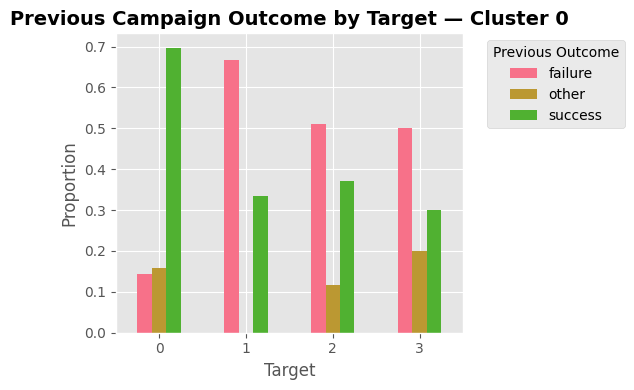

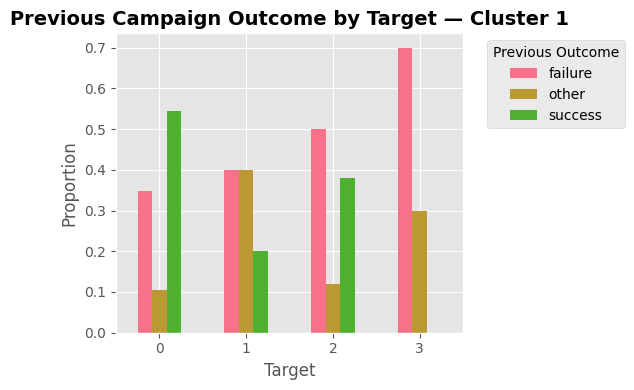

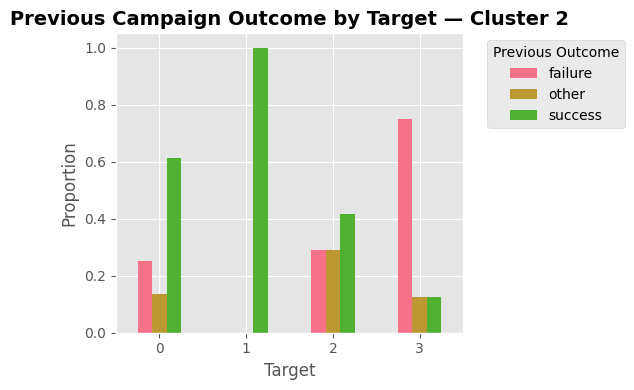

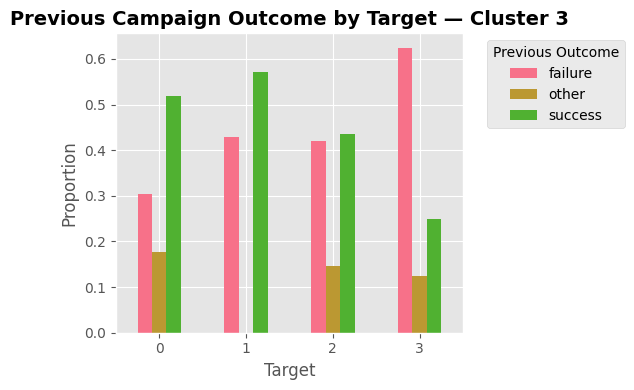

In [83]:
# Create individual cluster visualizations for contact patterns (non-unknown poutcome)
for cluster in clusters:
    cluster_data = data_bi[data_bi['cluster'] == cluster]
    # Filter out 'unknown' poutcome values for this cluster
    cluster_filtered = cluster_data[cluster_data['poutcome'] != 'unknown']
    
    if len(cluster_filtered) > 0:  # Only create plot if there's data
        fig, ax = plt.subplots(figsize=(6, 4))
        
        # Calculate normalized crosstab for this cluster by target
        poutcome_target = pd.crosstab(
            cluster_filtered['target'], cluster_filtered['poutcome'], normalize='index'
        )
        
        poutcome_target.plot(kind='bar', ax=ax)
        ax.set_title(f'Previous Campaign Outcome by Target — {cluster}', 
                     fontsize=14, fontweight='bold')
        ax.set_xlabel('Target')
        ax.set_ylabel('Proportion')
        ax.tick_params(axis='x', rotation=0)
        ax.legend(title='Previous Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No non-'unknown' poutcome data available for {cluster}")

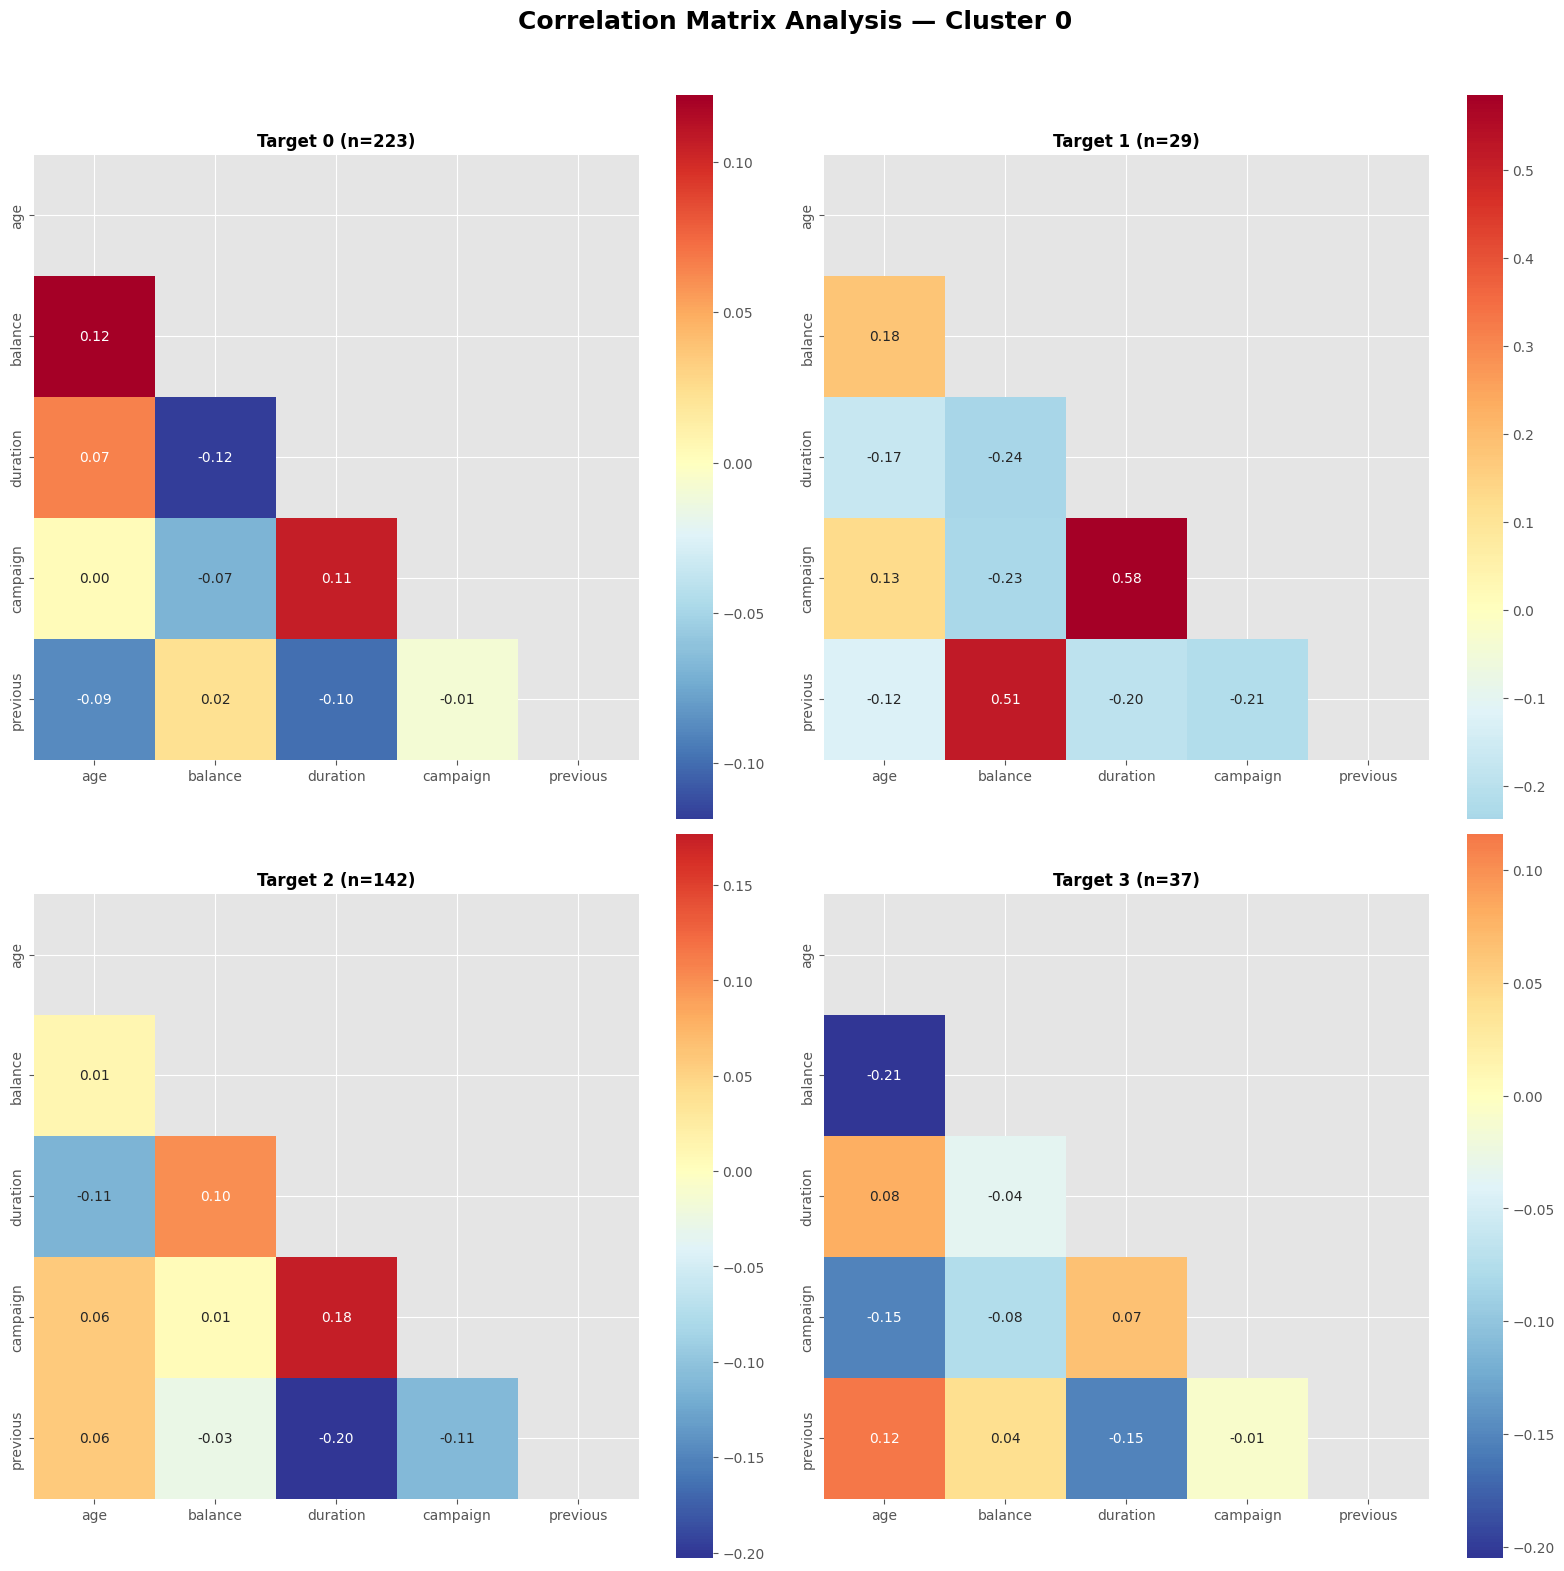

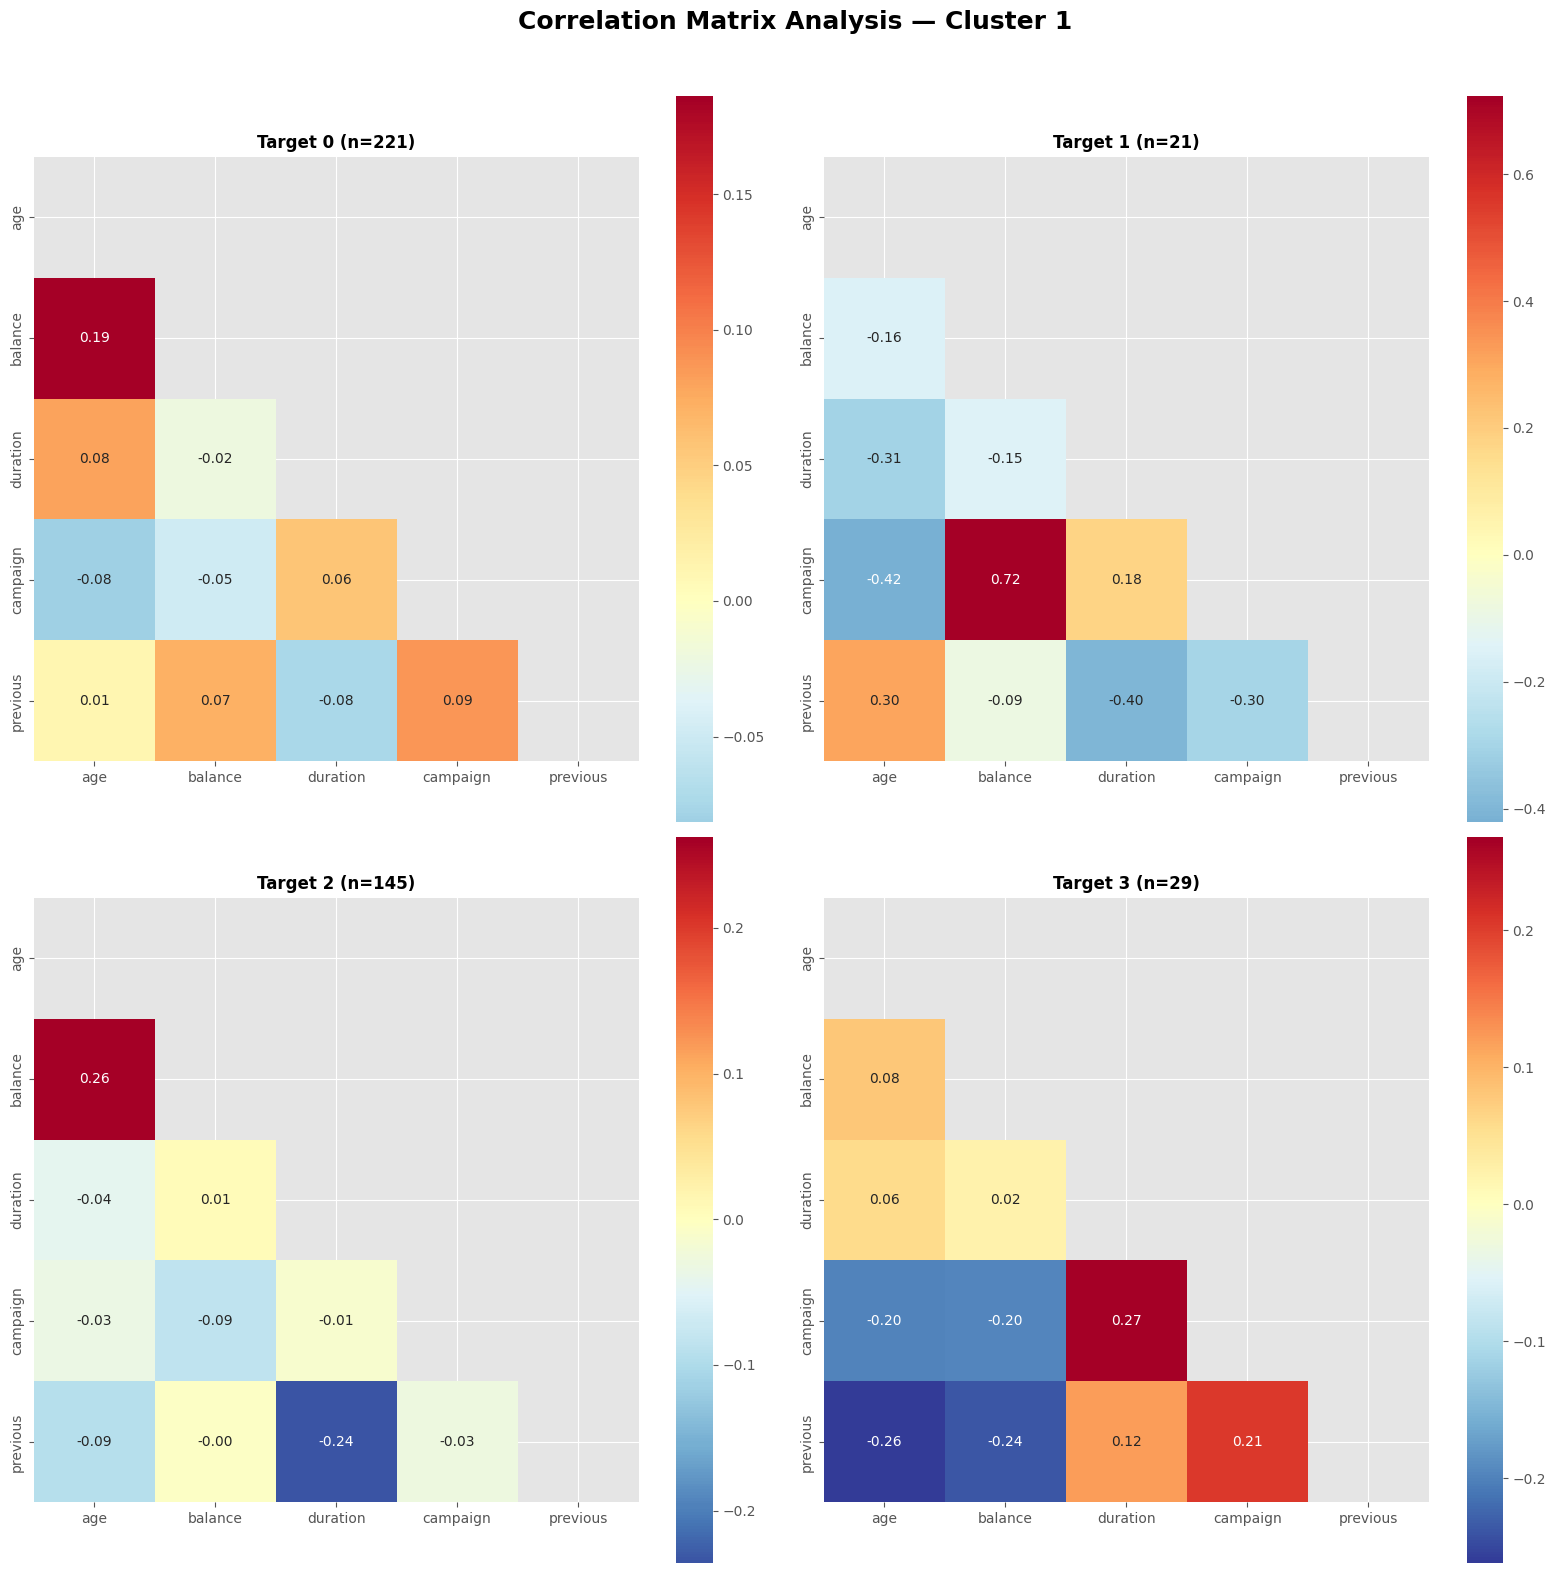

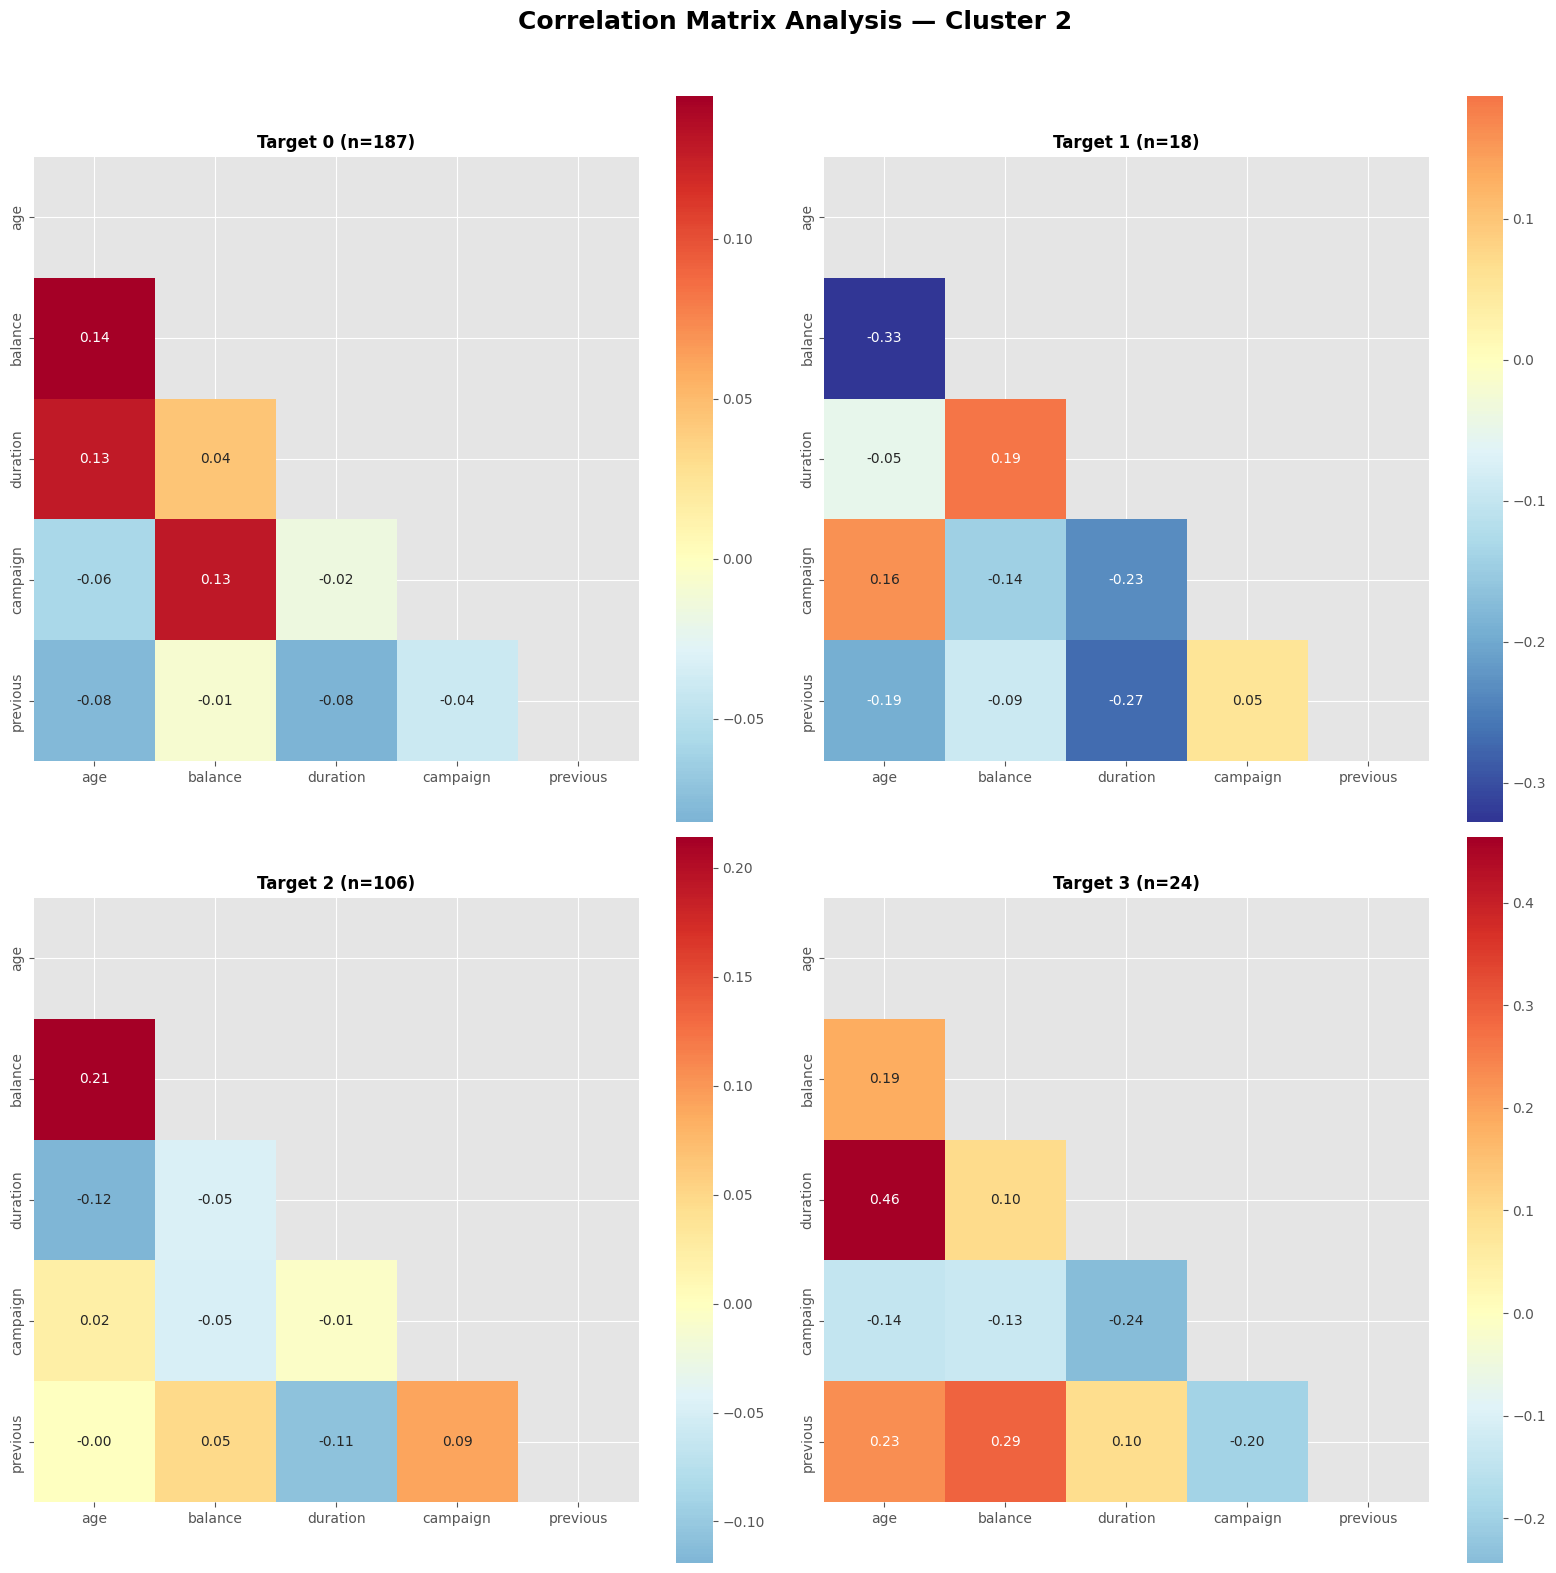

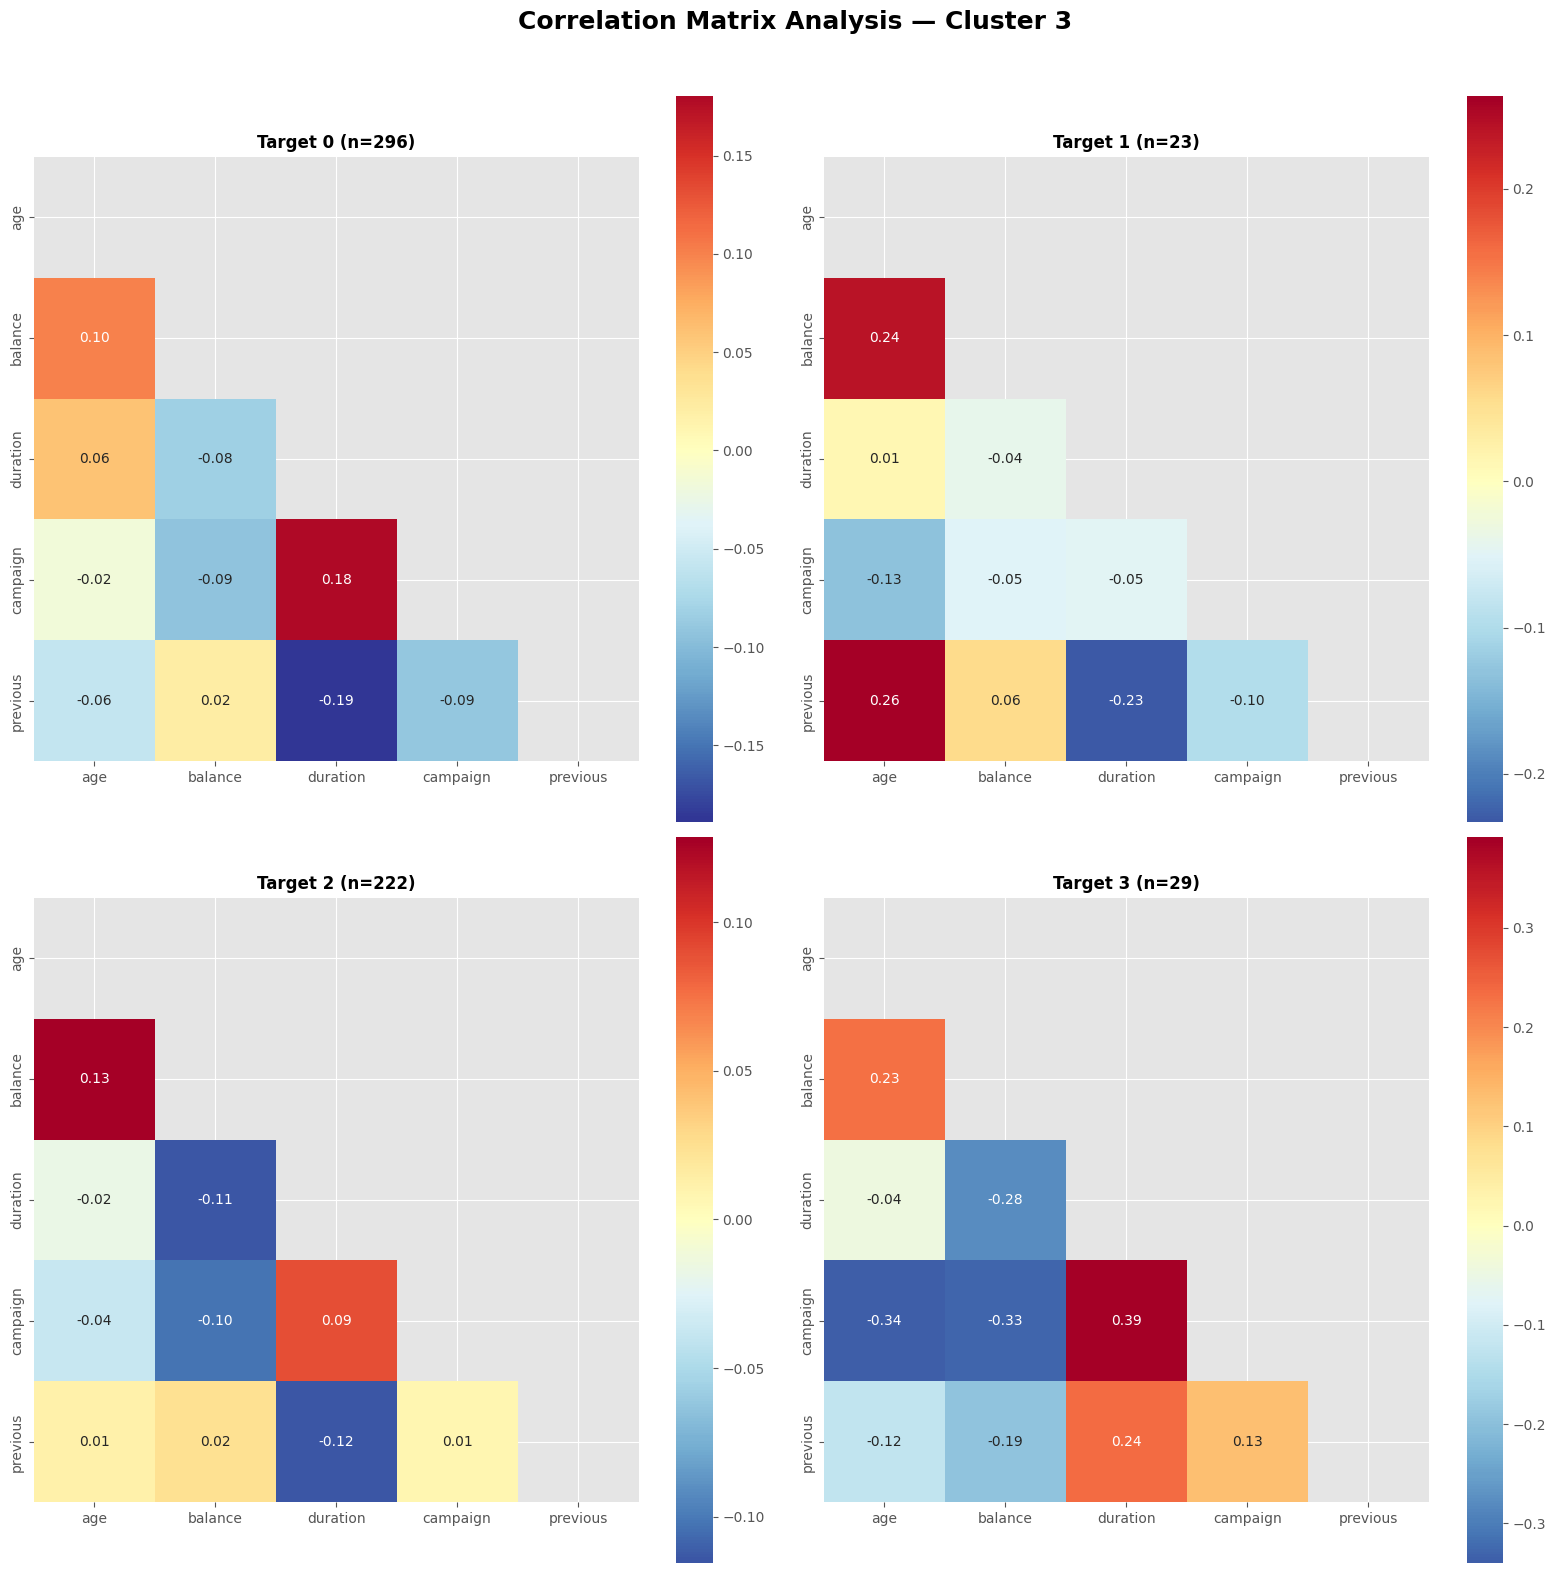

In [84]:
# Define numeric columns for correlation analysis
numeric_cols = ['age', 'balance', 'duration', 'campaign', 'previous']

# Create correlation heatmaps for each cluster
for cluster in clusters:
    cluster_data = data_bi[data_bi['cluster'] == cluster]
    
    # Get unique targets for this cluster
    cluster_targets = sorted(cluster_data['target'].unique())
    
    # Calculate subplot grid dimensions
    n_targets = len(cluster_targets)
    cols = 2
    rows = (n_targets + 1) // 2
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 8*rows))
    fig.suptitle(f'Correlation Matrix Analysis — {cluster}', fontsize=18, fontweight='bold')
    
    # Flatten axes for easier indexing
    if rows > 1:
        axes = axes.flatten()
    elif n_targets == 1:
        axes = [axes]
    
    for i, target_val in enumerate(cluster_targets):
        if i < len(axes):
            target_cluster_data = cluster_data[cluster_data['target'] == target_val][numeric_cols]
            
            if len(target_cluster_data) > 1:  # Need at least 2 samples for correlation
                correlation_matrix = target_cluster_data.corr()
                mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
                
                sns.heatmap(
                    correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
                    square=True, ax=axes[i], mask=mask, fmt='.2f'
                )
                axes[i].set_title(f'Target {target_val} (n={len(target_cluster_data)})', 
                                 fontsize=12, fontweight='bold')
            else:
                axes[i].text(0.5, 0.5, f'Target {target_val}\nInsufficient data\n(n={len(target_cluster_data)})', 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_xticks([])
                axes[i].set_yticks([])
    
    # Hide unused subplots
    for j in range(len(cluster_targets), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


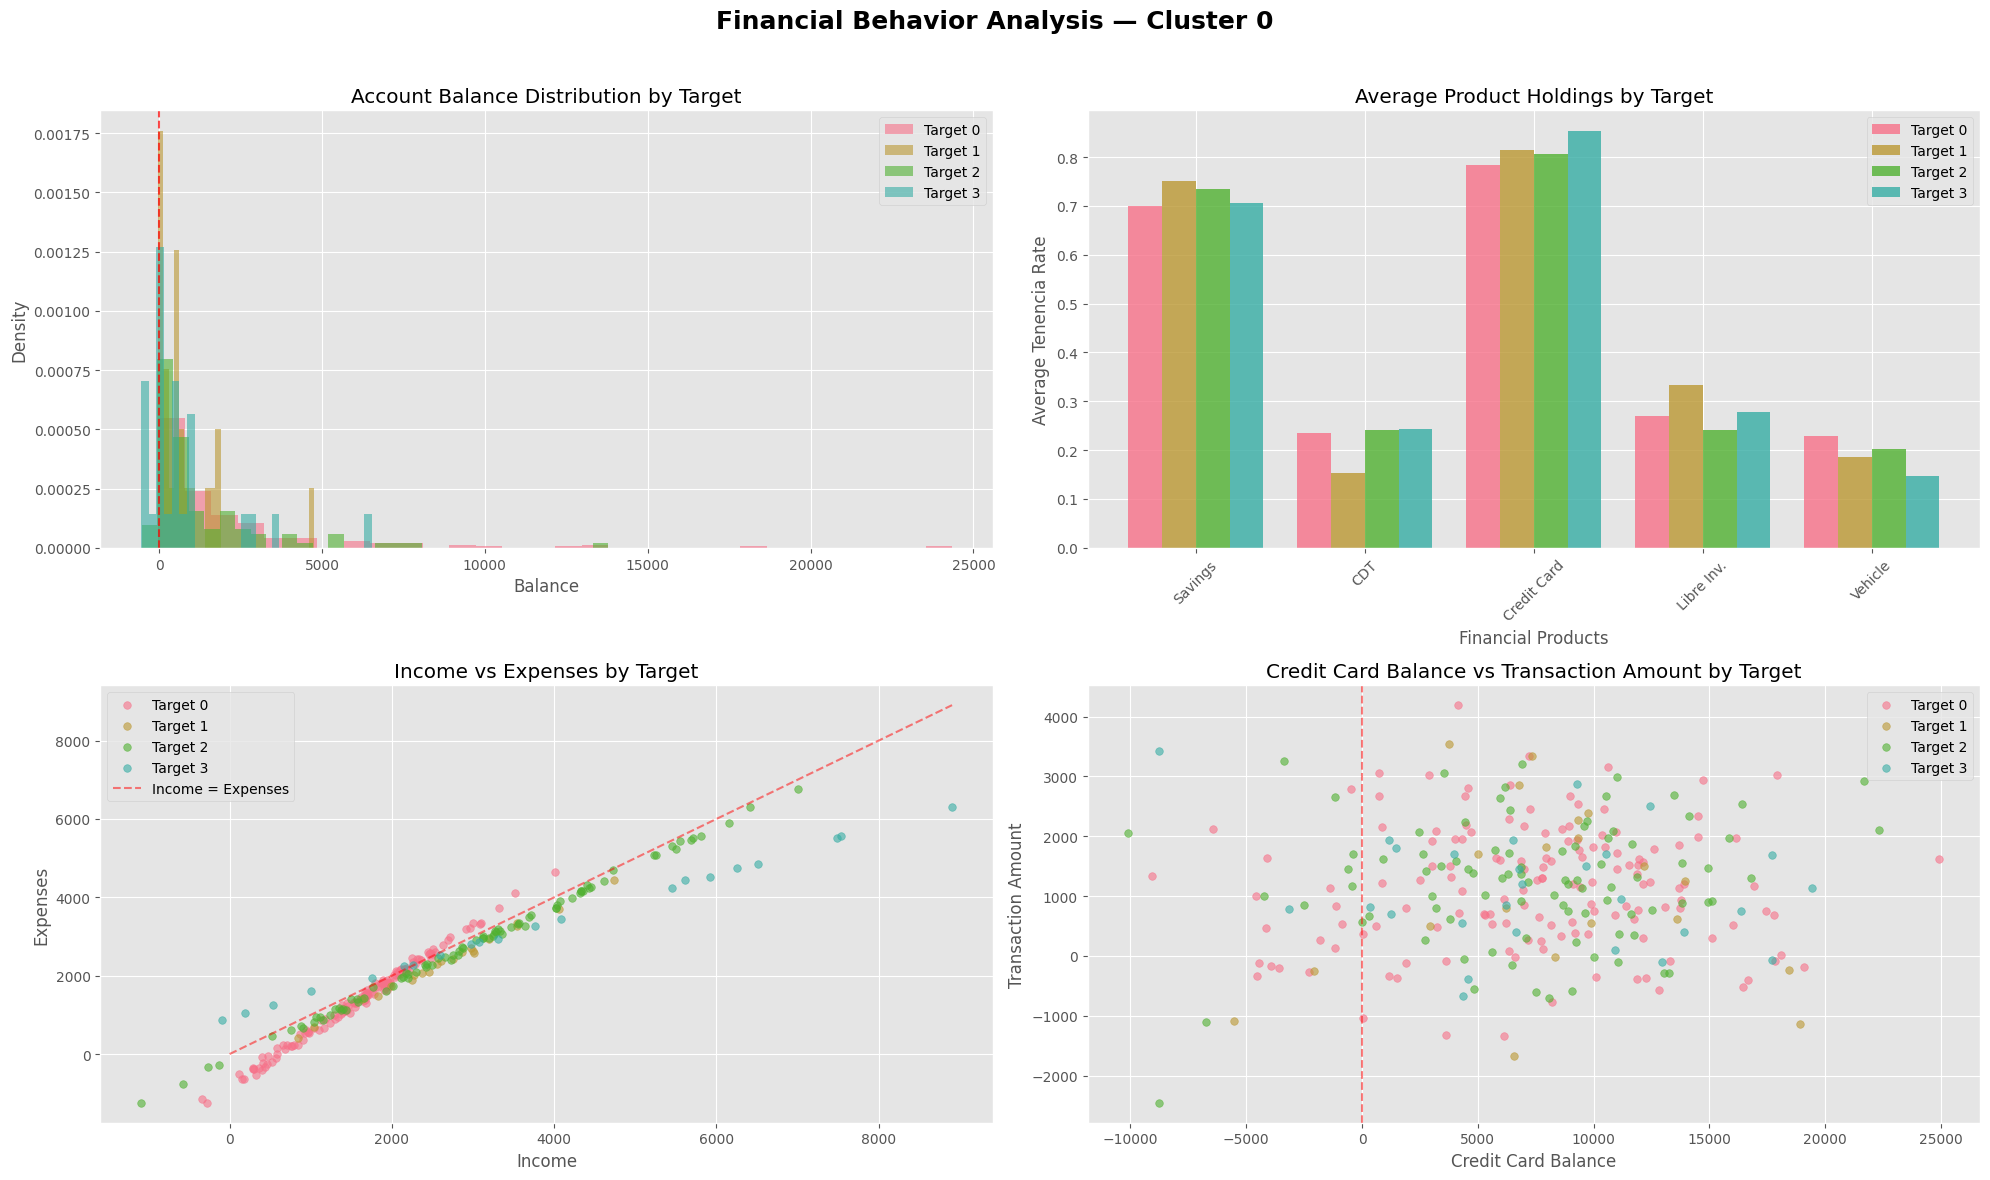

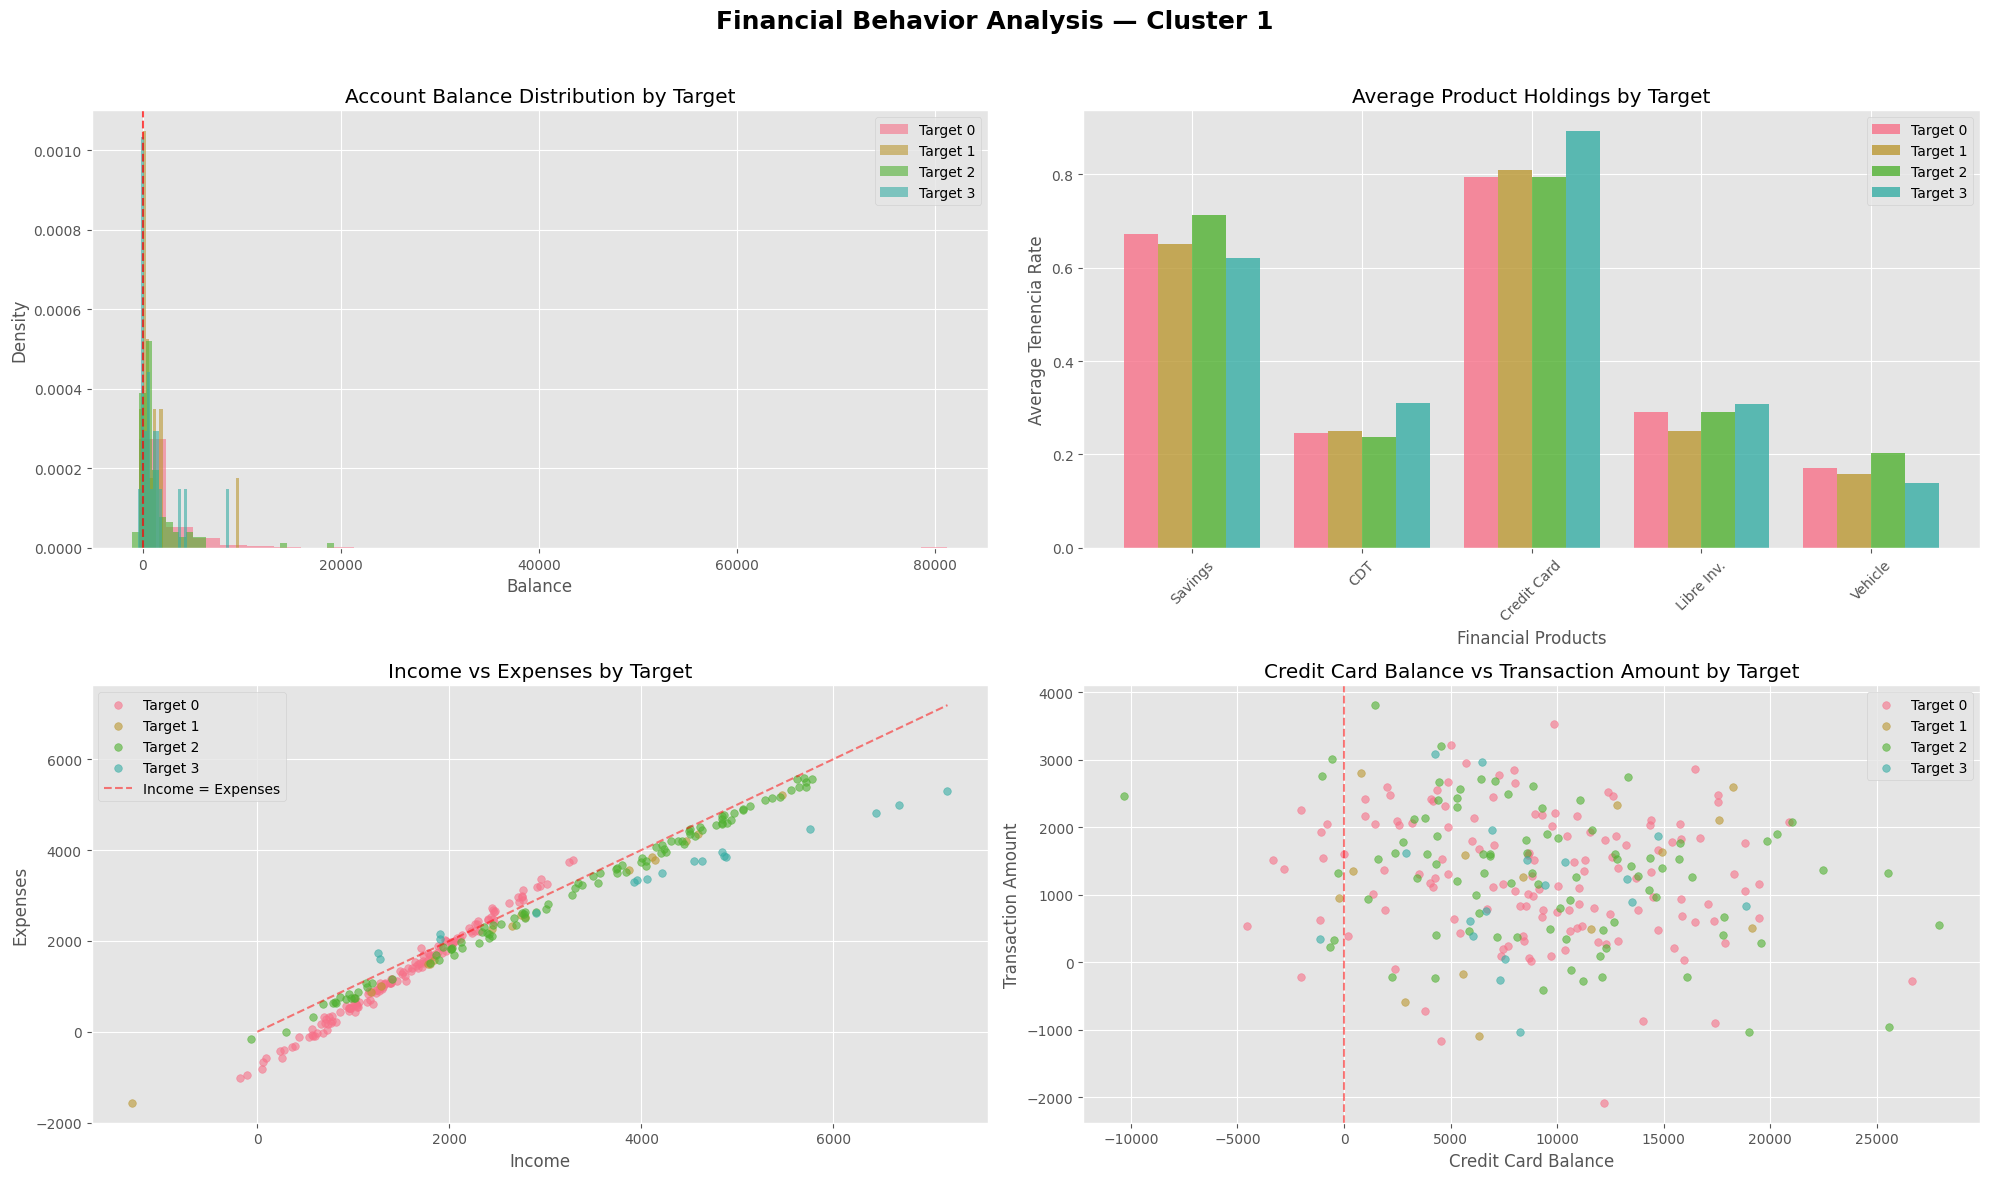

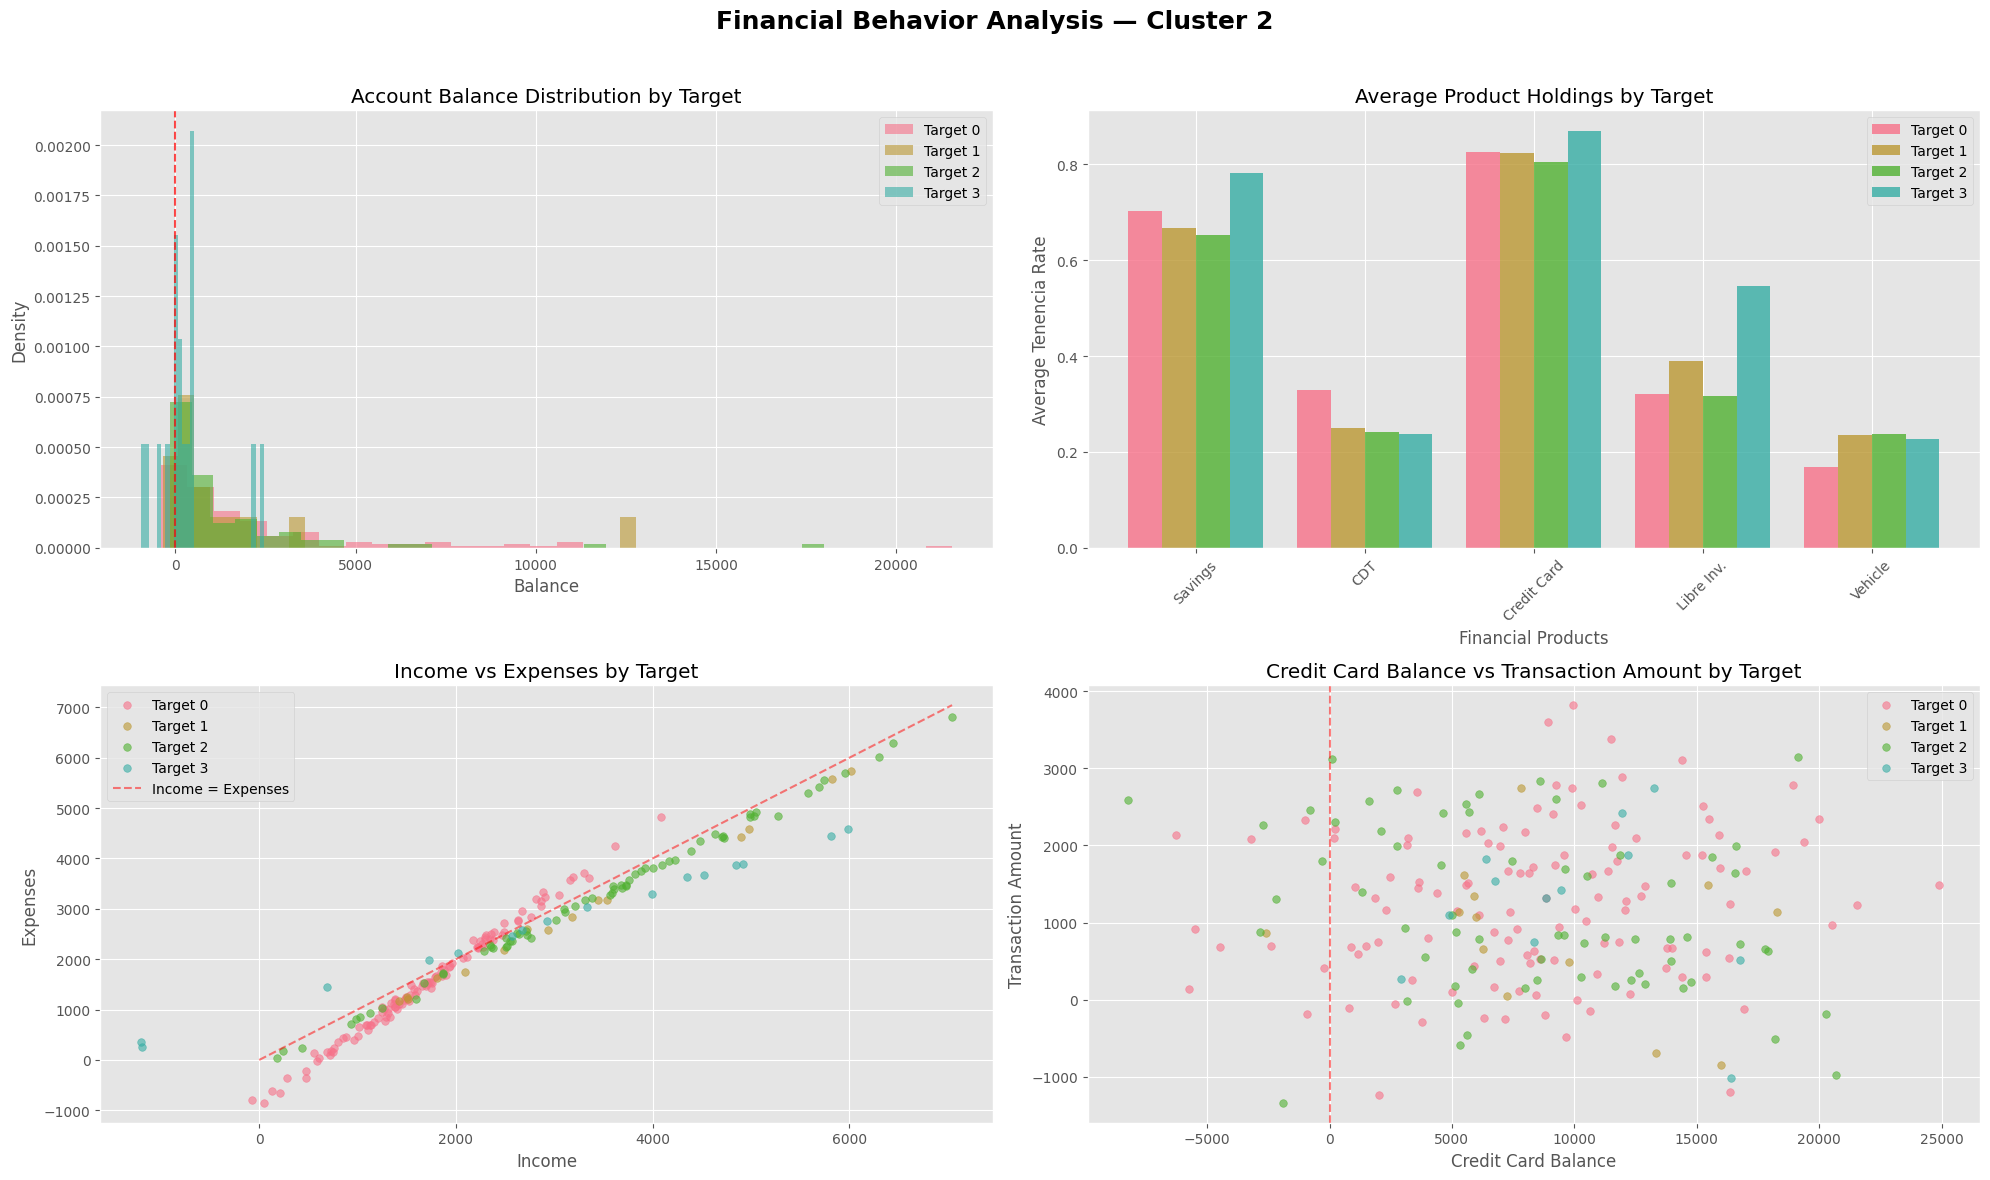

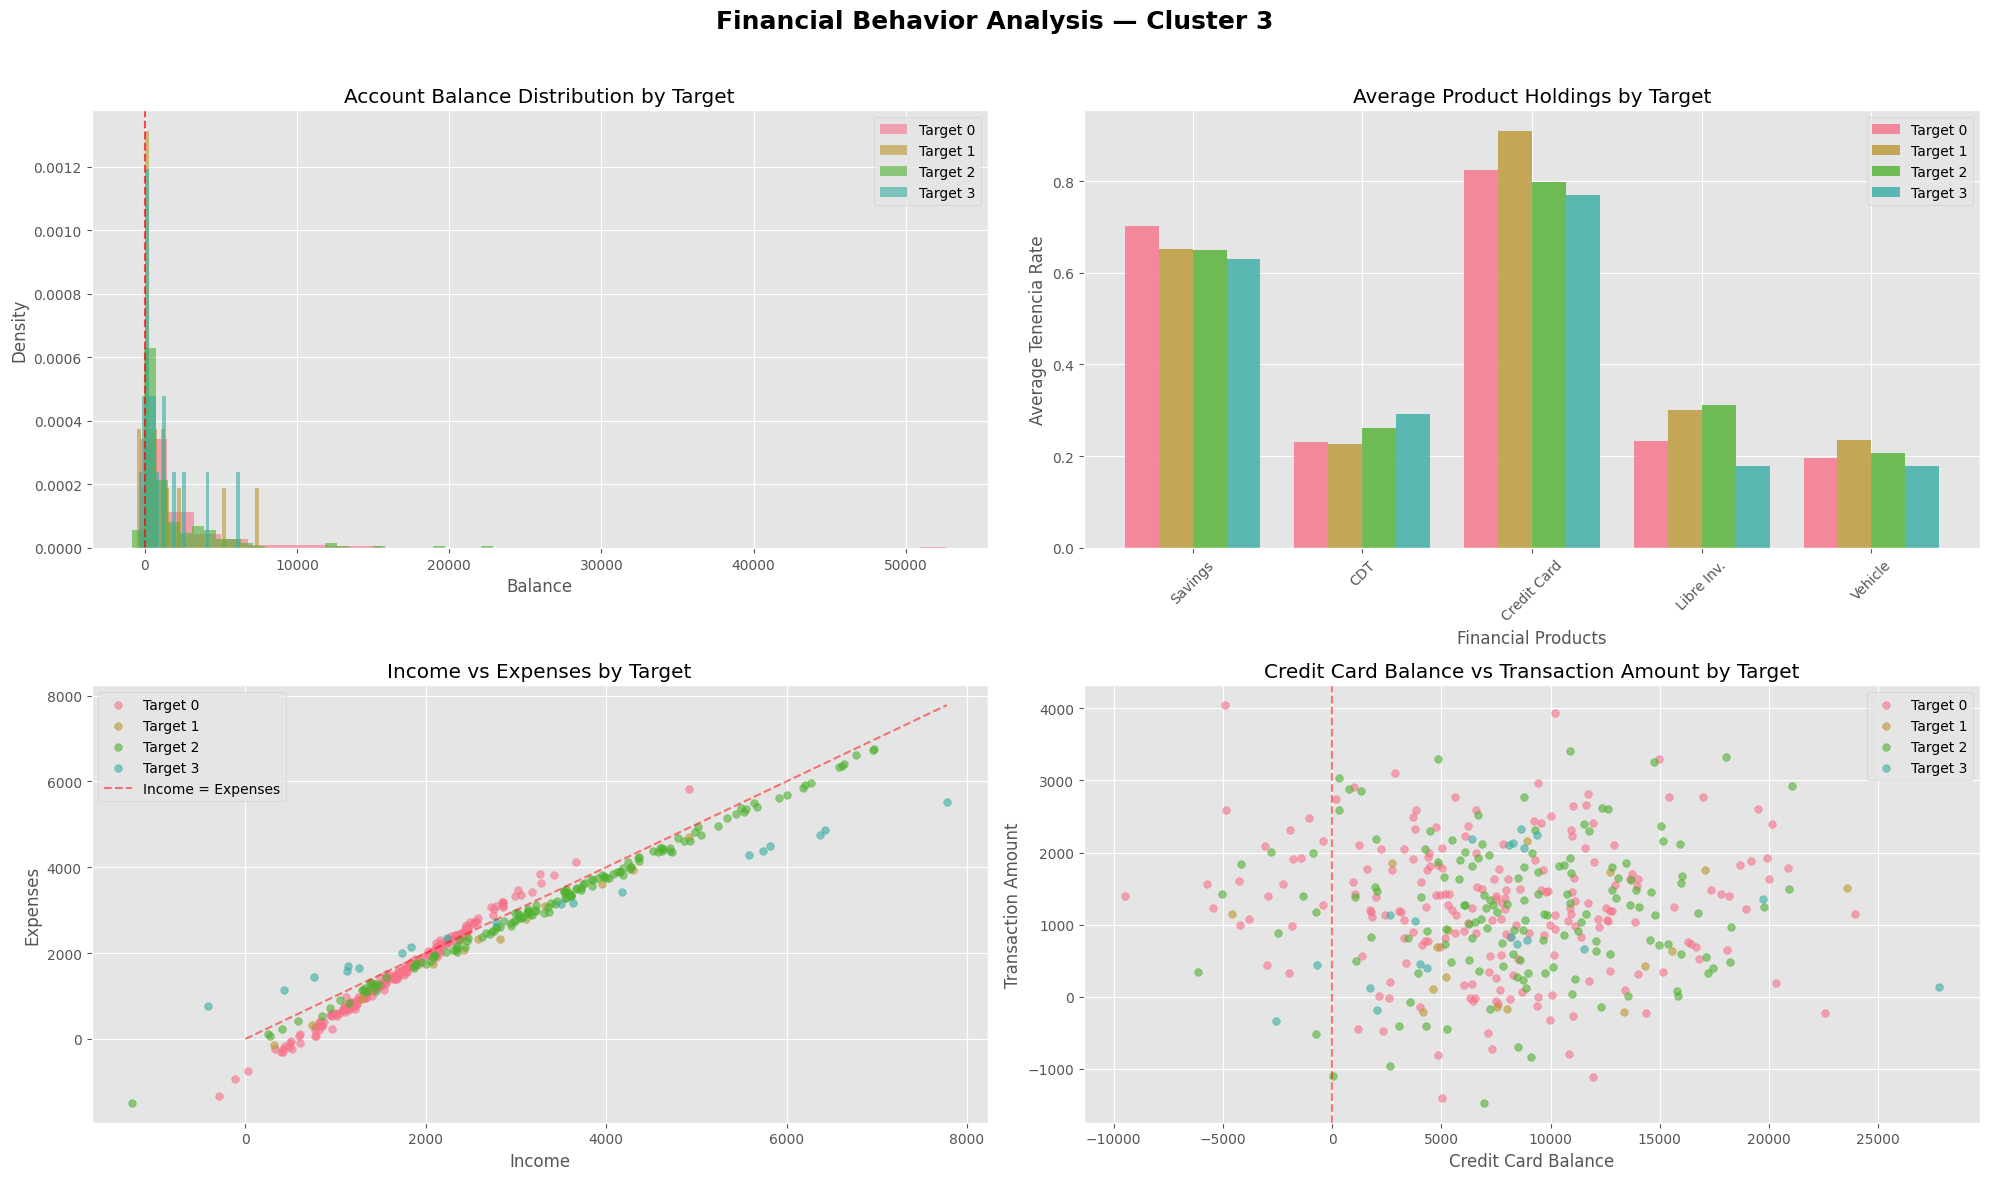

In [85]:
# Financial Behavior Analysis by Cluster and Target
for cluster in clusters:
    cluster_data = data_bi[data_bi['cluster'] == cluster]
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle(f'Financial Behavior Analysis — {cluster}', fontsize=18, fontweight='bold')
    
    # 1. Balance Distribution by Target
    for target_val in targets:
        target_cluster_data = cluster_data[cluster_data['target'] == target_val]
        balance_data = target_cluster_data['balance'].dropna()
        if len(balance_data) > 0:
            axes[0, 0].hist(balance_data, bins=30, alpha=0.6, 
                           label=f'Target {target_val}', density=True)
    axes[0, 0].set_title('Account Balance Distribution by Target')
    axes[0, 0].set_xlabel('Balance')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.7)
    
    # 2. Product Tenencia (Holdings) by Target
    tenencia_cols = ['tenencia_ahorros', 'tenencia_cdt', 'tenencia_tdc', 'tenencia_lb', 'tenencia_vehiculo']
    tenencia_means = []
    target_labels = []
    
    for target_val in targets:
        target_cluster_data = cluster_data[cluster_data['target'] == target_val]
        if len(target_cluster_data) > 0:
            tenencia_mean = target_cluster_data[tenencia_cols].mean()
            tenencia_means.append(tenencia_mean.values)
            target_labels.append(f'Target {target_val}')
    
    if tenencia_means:
        x = np.arange(len(tenencia_cols))
        width = 0.2
        for i, (means, label) in enumerate(zip(tenencia_means, target_labels)):
            axes[0, 1].bar(x + i*width, means, width, label=label, alpha=0.8)
    
    axes[0, 1].set_title('Average Product Holdings by Target')
    axes[0, 1].set_xlabel('Financial Products')
    axes[0, 1].set_ylabel('Average Tenencia Rate')
    axes[0, 1].set_xticks(x + width * 1.5)
    axes[0, 1].set_xticklabels(['Savings', 'CDT', 'Credit Card', 'Libre Inv.', 'Vehicle'], rotation=45)
    axes[0, 1].legend()
    
    # 3. Income vs Expenses by Target
    for target_val in targets:
        target_cluster_data = cluster_data[cluster_data['target'] == target_val]
        income_expense_data = target_cluster_data[['ingresos', 'egresos']].dropna()
        if len(income_expense_data) > 0:
            axes[1, 0].scatter(income_expense_data['ingresos'], income_expense_data['egresos'], 
                             alpha=0.6, label=f'Target {target_val}', s=30)
    
    axes[1, 0].plot([0, cluster_data['ingresos'].max()], [0, cluster_data['ingresos'].max()], 
                   'r--', alpha=0.5, label='Income = Expenses')
    axes[1, 0].set_title('Income vs Expenses by Target')
    axes[1, 0].set_xlabel('Income')
    axes[1, 0].set_ylabel('Expenses')
    axes[1, 0].legend()
    
    # 4. Credit Card Usage (Saldo vs Transactions) by Target
    cc_data_available = cluster_data[['saldo_tdc', 'monto_trx_tdc', 'target']].dropna()
    
    if len(cc_data_available) > 0:
        for target_val in targets:
            target_cc_data = cc_data_available[cc_data_available['target'] == target_val]
            if len(target_cc_data) > 0:
                axes[1, 1].scatter(target_cc_data['saldo_tdc'], target_cc_data['monto_trx_tdc'], 
                                 alpha=0.6, label=f'Target {target_val}', s=30)
        
        axes[1, 1].set_title('Credit Card Balance vs Transaction Amount by Target')
        axes[1, 1].set_xlabel('Credit Card Balance')
        axes[1, 1].set_ylabel('Transaction Amount')
        axes[1, 1].legend()
        axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.5)
    else:
        axes[1, 1].text(0.5, 0.5, 'No Credit Card Data Available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Credit Card Balance vs Transaction Amount by Target')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [87]:
cluster_data.to_excel(os.path.join(data_dir, 'processed', '04_data_prueba_ds_loan_housing_clusters_raw_merge.xlsx'), index=True, engine='openpyxl')